In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests

In [2]:
df = pd.read_pickle('../data/pkl/raw_games_5yrs.pkl')

In [3]:
df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])

In [4]:
df = df.sort_values(by='GAME_DATE', ascending=False)

In [5]:
# df = df[df['GAME_DATE'] > "2022-09-01"].sort_values(by='GAME_DATE', ascending=False)

In [6]:
df.reset_index(drop=True, inplace=True)

In [7]:
df.dtypes.value_counts()

int64             13
float64            9
object             5
int32              1
datetime64[ns]     1
dtype: int64

In [8]:
feat_categorical_nunique = df.select_dtypes(include='object').nunique()

In [9]:
feat_categorical_nunique

SEASON_ID              19
TEAM_ABBREVIATION      30
TEAM_NAME              30
MATCHUP              1777
WL                      2
dtype: int64

In [10]:
df.sort_values(['GAME_DATE', 'GAME_ID', 'HOME_TEAM'], ascending=[False, False, False], inplace=True)

## REMOVING SINGLE GAME ROWS

In [11]:
value_counts = df['GAME_ID'].value_counts()

In [12]:
unique_values = value_counts[value_counts == 1].index.tolist()

In [13]:
df = df[~df['GAME_ID'].isin(unique_values)]

In [14]:
df = df.reset_index(drop=True)

## PREPROCESS

In [15]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [16]:
scaler = MinMaxScaler()

In [17]:
selected_columns = ['FG_PCT', 'FG3_PCT', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF']

In [18]:
df[selected_columns] = scaler.fit_transform(df[selected_columns])

In [19]:
# ohe = OneHotEncoder(sparse=False)
# ohe.fit_transform(df[['TEAM_ABBREVIATION']])
# df[ohe.get_feature_names_out()] = ohe.transform(df[['TEAM_ABBREVIATION']])

In [20]:
# df.drop(columns = ["TEAM_ABBREVIATION"], inplace = True)

In [21]:
# df.columns

In [22]:
# ohe.get_feature_names_out()

## ROLLING

### ROLLING MEAN, MEDIAN, STD

In [23]:
def roll(roll_number = 10, procedure = 'mean', suff = '_rolling'):
    
    df_rolling = df[selected_columns + ["TEAM_NAME", "GAME_DATE"]]
    df_rolling.sort_values(['GAME_DATE'], ascending=True, inplace=True)
    df_rolling = df_rolling.groupby(["TEAM_NAME"], group_keys=False)
    
    def find_team_averages(team):
        return team.rolling(roll_number).mean()

    def find_team_medians(team):
        return team.rolling(roll_number).median()
    
    def find_team_stds(team):
        return team.rolling(roll_number).std()
    
    if procedure == 'mean':
        df_rolling = df_rolling.apply(find_team_averages)
    elif procedure == 'median':
        df_rolling = df_rolling.apply(find_team_medians)
    elif procedure == 'std':
        df_rolling = df_rolling.apply(find_team_stds)
    else:
        df_rolling = df_rolling.apply(find_team_averages)
        
    df_rolling = df_rolling[selected_columns]
    df_rolling = df_rolling.sort_index()
    
    new_column_names = {}
    for col in df_rolling.columns:
        new_column_names[col] = col + suff

    df_rolling = df_rolling.rename(columns=new_column_names)
    return df_rolling

In [24]:
df_rolling10_mean = roll(roll_number = 10, procedure = 'mean', suff = '_rolling10_mean')
df_rolling5_mean = roll(roll_number = 5, procedure = 'mean', suff = '_rolling5_mean')
df_rolling10_median = roll(roll_number = 10, procedure = 'median', suff = '_rolling10_median')
df_rolling5_median = roll(roll_number = 5, procedure = 'median', suff = '_rolling5_median')
df_rolling10_std = roll(roll_number = 10, procedure = 'std', suff = '_rolling10_std')
df_rolling5_std = roll(roll_number = 5, procedure = 'std', suff = '_rolling5_std')

/var/folders/ry/bbrg927549539gbw_r9_cqyc0000gn/T/ipykernel_66257/3965639424.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rolling.sort_values(['GAME_DATE'], ascending=True, inplace=True)
/var/folders/ry/bbrg927549539gbw_r9_cqyc0000gn/T/ipykernel_66257/3965639424.py:8: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['GAME_DATE', 'TEAM_NAME'], dtype='object')
  return team.rolling(roll_number).mean()
/var/folders/ry/bbrg927549539gbw_r9_cqyc0000gn/T/ipykernel_66257/3965639424.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/

### COMBINING ROLLING COLUMNS

In [25]:
combined_df = pd.concat([df, df_rolling10_mean, df_rolling5_mean, df_rolling10_median, df_rolling5_median, df_rolling10_std, df_rolling5_std], axis=1)

In [26]:
combined_df = combined_df.drop(columns=selected_columns)

In [27]:
combined_df = combined_df.dropna()

In [28]:
combined_df.columns

Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'PTS', 'FGM', 'FGA', 'FG3M',
       'FG3A', 'FTM', 'FTA', 'PLUS_MINUS', 'HOME_TEAM',
       'FG_PCT_rolling10_mean', 'FG3_PCT_rolling10_mean',
       'FT_PCT_rolling10_mean', 'OREB_rolling10_mean', 'DREB_rolling10_mean',
       'REB_rolling10_mean', 'AST_rolling10_mean', 'STL_rolling10_mean',
       'BLK_rolling10_mean', 'TOV_rolling10_mean', 'PF_rolling10_mean',
       'FG_PCT_rolling5_mean', 'FG3_PCT_rolling5_mean', 'FT_PCT_rolling5_mean',
       'OREB_rolling5_mean', 'DREB_rolling5_mean', 'REB_rolling5_mean',
       'AST_rolling5_mean', 'STL_rolling5_mean', 'BLK_rolling5_mean',
       'TOV_rolling5_mean', 'PF_rolling5_mean', 'FG_PCT_rolling10_median',
       'FG3_PCT_rolling10_median', 'FT_PCT_rolling10_median',
       'OREB_rolling10_median', 'DREB_rolling10_median',
       'REB_rolling10_median', 'AST_rolling10_median', 'STL_rolling10_median',
       'BLK_rolling

## COMBINING HOME AWAY ROWS

In [29]:
df_in_process = combined_df.drop(columns=['SEASON_ID', 'WL', 'MIN', 'MATCHUP', 'PTS', 'TEAM_ID', 'TEAM_NAME', 'FTM', 'FTA', 'FGM', 'FGA', 'FG3M', 'FG3A', 'HOME_TEAM'])

In [30]:
df_in_process.columns

Index(['TEAM_ABBREVIATION', 'GAME_ID', 'GAME_DATE', 'PLUS_MINUS',
       'FG_PCT_rolling10_mean', 'FG3_PCT_rolling10_mean',
       'FT_PCT_rolling10_mean', 'OREB_rolling10_mean', 'DREB_rolling10_mean',
       'REB_rolling10_mean', 'AST_rolling10_mean', 'STL_rolling10_mean',
       'BLK_rolling10_mean', 'TOV_rolling10_mean', 'PF_rolling10_mean',
       'FG_PCT_rolling5_mean', 'FG3_PCT_rolling5_mean', 'FT_PCT_rolling5_mean',
       'OREB_rolling5_mean', 'DREB_rolling5_mean', 'REB_rolling5_mean',
       'AST_rolling5_mean', 'STL_rolling5_mean', 'BLK_rolling5_mean',
       'TOV_rolling5_mean', 'PF_rolling5_mean', 'FG_PCT_rolling10_median',
       'FG3_PCT_rolling10_median', 'FT_PCT_rolling10_median',
       'OREB_rolling10_median', 'DREB_rolling10_median',
       'REB_rolling10_median', 'AST_rolling10_median', 'STL_rolling10_median',
       'BLK_rolling10_median', 'TOV_rolling10_median', 'PF_rolling10_median',
       'FG_PCT_rolling5_median', 'FG3_PCT_rolling5_median',
       'FT_PCT_rolli

In [31]:
home_df = df_in_process.iloc[::2].reset_index(drop=True)

In [32]:
away_df = df_in_process.iloc[1::2].reset_index(drop=True)

In [33]:
new_column_names = {}
for col in home_df.columns:
    new_column_names[col] = col + '_h'

# rename the columns using the dictionary
home_df = home_df.rename(columns=new_column_names)

In [34]:
new_column_names = {}
for col in away_df.columns:
    new_column_names[col] = col + '_a'

# rename the columns using the dictionary
away_df = away_df.rename(columns=new_column_names)

In [35]:
home_df.columns

Index(['TEAM_ABBREVIATION_h', 'GAME_ID_h', 'GAME_DATE_h', 'PLUS_MINUS_h',
       'FG_PCT_rolling10_mean_h', 'FG3_PCT_rolling10_mean_h',
       'FT_PCT_rolling10_mean_h', 'OREB_rolling10_mean_h',
       'DREB_rolling10_mean_h', 'REB_rolling10_mean_h', 'AST_rolling10_mean_h',
       'STL_rolling10_mean_h', 'BLK_rolling10_mean_h', 'TOV_rolling10_mean_h',
       'PF_rolling10_mean_h', 'FG_PCT_rolling5_mean_h',
       'FG3_PCT_rolling5_mean_h', 'FT_PCT_rolling5_mean_h',
       'OREB_rolling5_mean_h', 'DREB_rolling5_mean_h', 'REB_rolling5_mean_h',
       'AST_rolling5_mean_h', 'STL_rolling5_mean_h', 'BLK_rolling5_mean_h',
       'TOV_rolling5_mean_h', 'PF_rolling5_mean_h',
       'FG_PCT_rolling10_median_h', 'FG3_PCT_rolling10_median_h',
       'FT_PCT_rolling10_median_h', 'OREB_rolling10_median_h',
       'DREB_rolling10_median_h', 'REB_rolling10_median_h',
       'AST_rolling10_median_h', 'STL_rolling10_median_h',
       'BLK_rolling10_median_h', 'TOV_rolling10_median_h',
       'PF_rollin

In [36]:
away_df.columns

Index(['TEAM_ABBREVIATION_a', 'GAME_ID_a', 'GAME_DATE_a', 'PLUS_MINUS_a',
       'FG_PCT_rolling10_mean_a', 'FG3_PCT_rolling10_mean_a',
       'FT_PCT_rolling10_mean_a', 'OREB_rolling10_mean_a',
       'DREB_rolling10_mean_a', 'REB_rolling10_mean_a', 'AST_rolling10_mean_a',
       'STL_rolling10_mean_a', 'BLK_rolling10_mean_a', 'TOV_rolling10_mean_a',
       'PF_rolling10_mean_a', 'FG_PCT_rolling5_mean_a',
       'FG3_PCT_rolling5_mean_a', 'FT_PCT_rolling5_mean_a',
       'OREB_rolling5_mean_a', 'DREB_rolling5_mean_a', 'REB_rolling5_mean_a',
       'AST_rolling5_mean_a', 'STL_rolling5_mean_a', 'BLK_rolling5_mean_a',
       'TOV_rolling5_mean_a', 'PF_rolling5_mean_a',
       'FG_PCT_rolling10_median_a', 'FG3_PCT_rolling10_median_a',
       'FT_PCT_rolling10_median_a', 'OREB_rolling10_median_a',
       'DREB_rolling10_median_a', 'REB_rolling10_median_a',
       'AST_rolling10_median_a', 'STL_rolling10_median_a',
       'BLK_rolling10_median_a', 'TOV_rolling10_median_a',
       'PF_rollin

In [37]:
home_df = home_df.rename(columns={'GAME_ID_h': 'GAME_ID'})

In [38]:
away_df = away_df.rename(columns={'GAME_ID_a': 'GAME_ID'})

In [39]:
home_df = home_df.drop(columns=['GAME_DATE_h'])

In [40]:
away_df = away_df.drop(columns=['PLUS_MINUS_a', 'GAME_DATE_a'])

In [41]:
combined_df = pd.merge(home_df, away_df, on='GAME_ID')
combined_df

TEAM_ABBREVIATION_h   GAME_ID  PLUS_MINUS_h  FG_PCT_rolling10_mean_h  \
0                    WAS  22200973          -6.0                 0.607175   
1                    LAC  22200970           6.0                 0.558072   
2                    BOS  22200969          -2.0                 0.529596   
3                    OKC  22200968          10.0                 0.515919   
4                    HOU  22200967          32.0                 0.495291   
...                  ...       ...           ...                      ...   
6553                 MEM  21701092          -7.0                 0.415471   
6554                 HOU  21701091          23.0                 0.491031   
6555                 CHI  21701089         -22.0                 0.424888   
6556                 SAS  21701085           5.0                 0.480493   
6557                 LAC  21701078          -5.0                 0.548879   

      FG3_PCT_rolling10_mean_h  FT_PCT_rolling10_mean_h  \
0                     0.428235                 0.776662   
1                     0.389804                 0.783718   
2                     0.416993                 0.714111   
3                     0.345229                 0.716282   
4                     0.330065                 0.677205   
...                        ...                      ...   
6553                  0.327974                 0.648982   
6554                  0.372288                 0.633243   
6555                  0.346928                 0.713433   
6556                  0.353856                 0.703121   
6557                  0.366144                 0.617503   

      OREB_rolling10_mean_h  DREB_rolling10_mean_h  REB_rolling10_mean_h  \
0                  0.358621               0.395556              0.415686   
1                  0.282759               0.395556              0.372549   
2                  0.362069               0.455556              0.470588   
3                  0.424138               0.337778              0.401961   
4                  0.455172               0.373333              0.450980   
...                     ...                    ...                   ...   
6553               0.375862               0.331111              0.368627   
6554               0.327586               0.444444              0.441176   
6555               0.400000               0.384444              0.429412   
6556               0.348276               0.420000              0.431373   
6557               0.358621               0.420000              0.437255   

      AST_rolling10_mean_h  ...  FG3_PCT_rolling5_std_a  \
0                 0.427907  ...                0.109410   
1                 0.446512  ...                0.159634   
2                 0.469767  ...                0.107718   
3                 0.432558  ...                0.041681   
4                 0.388372  ...                0.066699   
...                    ...  ...                     ...   
6553              0.332558  ...                0.122165   
6554              0.320930  ...                0.075521   
6555              0.423256  ...                0.161319   
6556              0.367442  ...                0.130291   
6557              0.355814  ...                0.115094   

      FT_PCT_rolling5_std_a  OREB_rolling5_std_a  DREB_rolling5_std_a  \
0                  0.292104             0.056661             0.102319   
1                  0.079566             0.154212             0.128236   
2                  0.097114             0.083045             0.136987   
3                  0.094057             0.093167             0.128620   
4                  0.183217             0.075548             0.134623   
...                     ...                  ...                  ...   
6553               0.100533             0.110129             0.112656   
6554               0.128709             0.089256             0.061664   
6555               0.187978             0.134439             0.132031   
6556               

In [42]:
import seaborn as sns

<Axes: >

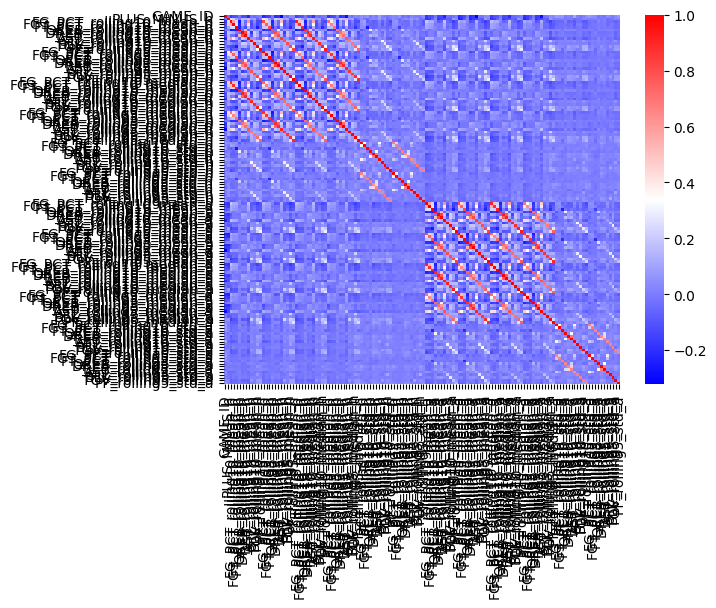

In [43]:
combined_df.drop(columns=['PLUS_MINUS_h'])

corr = combined_df.filter(regex='^(?!TEAM_ABBREVIATION)').corr() # Pearson Correlation

# Heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap= 'bwr')

In [44]:
corr_df = corr.stack().reset_index() # Unstack correlation matrix 

corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns

corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation

corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation

corr_df.head(10)

feature_1                feature_2  correlation
10012     AST_rolling10_mean_a   AST_rolling10_median_a     0.942956
12938   AST_rolling10_median_a     AST_rolling10_mean_a     0.942956
1102      AST_rolling10_mean_h   AST_rolling10_median_h     0.941463
4028    AST_rolling10_median_h     AST_rolling10_mean_h     0.941463
13478    PF_rolling10_median_a      PF_rolling10_mean_a     0.928626
10552      PF_rolling10_mean_a    PF_rolling10_median_a     0.928626
1642       PF_rolling10_mean_h    PF_rolling10_median_h     0.928183
4568     PF_rolling10_median_h      PF_rolling10_mean_h     0.928183
832      DREB_rolling10_mean_h  DREB_rolling10_median_h     0.921094
3758   DREB_rolling10_median_h    DREB_rolling10_mean_h     0.921094

## X, y

In [45]:
X = combined_df.drop(columns=['PLUS_MINUS_h'])
y = combined_df.PLUS_MINUS_h

In [46]:
# X.drop(columns=['SEASON_ID', 'WL', 'MIN', 'MATCHUP', 'PTS', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'FTM', 'FTA', 'FGM', 'FGA', 'FG3M', 'FG3A'], inplace=True)

In [47]:
X.drop(columns=['GAME_ID'], inplace=True)

In [48]:
# X.filter(regex='^(?!TEAM_ABBREVIATION)').columns

In [49]:
# X.to_pickle('X_basic_df_2022-09-01.pkl')

In [50]:
# y.to_pickle('y_basic_df_2022-09-01.pkl')

In [51]:
# X.to_pickle('X_basic_df_5yrs_preprocessed.pkl')

In [52]:
# y.to_pickle('y_basic_df_5yrs_preprocessed.pkl')

In [53]:
# X.to_pickle('X_basic_rolling_df_5yrs_preprocessed.pkl')

In [54]:
# y.to_pickle('y_basic_rolling_df_5yrs_preprocessed.pkl')

In [55]:
# X.to_pickle('X_basic_df_5yrs_preprocessed_all_rolls.pkl')

In [56]:
# y.to_pickle('y_basic_df_5yrs_preprocessed_all_rolls.pkl')

In [57]:
X.to_pickle('X_basic_df_5yrs_preprocessed_without_ohe.pkl')

In [58]:
y.to_pickle('y_basic_df_5yrs_preprocessed_without_ohe.pkl')